In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from tqdm import tqdm

%matplotlib inline

c:\Users\katam\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#определим устройство, где проводить вычисления (GPU или CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
#функция для вывода изображений
def image_shower(images, labels, n=4):
    plt.figure(figsize=(12, 12))
    for i, image in enumerate(images[:n]):
        plt.subplot(n, n, i + 1)
        image = image/ 2 + 0.5
        plt.imshow(image.numpy().transpose((1, 2, 0)).squeeze())
    print("Real Labels: ", ' '.join('%5s' % classes[label] for label in labels[:n]))
#имена классов
classes = ("hotgot", "not_hot_dog")

#путь до датасета
PATH = "dataset"

In [11]:
# зададим какие преобразования необходимо сделать с каждым изображением
transform = transforms.Compose(
    [transforms.Resize((64,64)),  #изменим размер изображений
     transforms.ToTensor(),   #переведем в формат который необходим нейронной сети - тензор
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]) # проведем нормализацию изображения

#загружаем тренировочный и тестовый датасеты
trainset = torchvision.datasets.ImageFolder(os.path.join(PATH, "train"), transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, num_workers=0, shuffle=True)

testset = torchvision.datasets.ImageFolder(os.path.join(PATH, "test"), transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, num_workers=0, shuffle=True)


Real Labels:  not_hot_dog hotgot hotgot hotgot


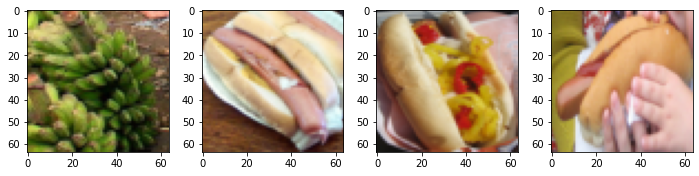

In [12]:
#Проверим как работает наш загрузчик и посмотрим на парочку изображений
images, labels = next(iter(trainloader))
image_shower(images, labels)

In [13]:
#загрузим нашу модель
model = torchvision.models.resnet18(pretrained=True)
#заморозим веса
for param in model.parameters():
    param.require = False

#так как у нас 2 класса, нужно переопределить последний слой сети под нашу задачу
#у предобученной сети было на выходе 1000 классов, поэтому в видео я сказал меняем 1000 на 2
model.fc = nn.Linear(512, 2)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\katam/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:05<00:00, 8.44MB/s]


In [14]:
#Зададим функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

In [15]:
#Здесь будет тренировка нейронной сети

epochs = 10   #количество эпох (сколько раз будем тренировать)
model.to(device) #переносим нашу модель на GPU

for epoch in range(epochs):
    running_loss = 0.0
    #теперь в цикле проходим по нашему загрузчику данных
    for i, data in tqdm(enumerate(trainloader)):
        #каждый батч тоже помещаем на GPU
        inputs, labels = data[0].to(device), data[1].to(device)
        #сбрасываем накопленный градиент 
        optimizer.zero_grad()
        #прогоняем изображения через модель, чтобы получить предсказание
        outputs = model(inputs)
        #рассчитываем функцию потерь (насколько хорошо предсказали)
        loss = criterion(outputs, labels)
        #считаем градиенты (обратный проход)
        loss.backward()
        #делаем шаг оптимизатора (обновляем веса)
        optimizer.step()

        running_loss += loss.item()

    print ("Epoch {} - Training loss: {} ".format(epoch, running_loss/len(trainloader)))

32it [01:50,  3.46s/it]


Epoch 0 - Training loss: 0.51980757759884 


32it [01:41,  3.17s/it]


Epoch 1 - Training loss: 0.18656549393199384 


32it [01:38,  3.07s/it]


Epoch 2 - Training loss: 0.09472615295089781 


32it [01:37,  3.05s/it]


Epoch 3 - Training loss: 0.05697096011135727 


32it [01:37,  3.04s/it]


Epoch 4 - Training loss: 0.03538863098947331 


32it [01:36,  3.01s/it]


Epoch 5 - Training loss: 0.028354233014397323 


32it [01:32,  2.88s/it]


Epoch 6 - Training loss: 0.02255456559942104 


32it [01:34,  2.96s/it]


Epoch 7 - Training loss: 0.018533946480602026 


32it [01:33,  2.93s/it]


Epoch 8 - Training loss: 0.013628151296870783 


32it [01:31,  2.87s/it]

Epoch 9 - Training loss: 0.017592102478374727 


In [16]:
#посчитаем точность работы нашего классификатора
correct = 0
total = 0
with torch.no_grad():
    #переводим модель в режим инференса
    model.eval()
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        #получаем наши предсказания
        _, predicted = torch.max(outputs.data, 1)
        #посчитаем общее количество картинок
        total += labels.size(0)
        #посчитаем количество точно классифицированных картинок
        correct += (predicted == labels).sum().item()
print("Accuracy: %d" %(100 * correct/total))


Accuracy: 92


Real Labels:  hotgot not_hot_dog not_hot_dog not_hot_dog
Predicted:  hotgot not_hot_dog not_hot_dog not_hot_dog


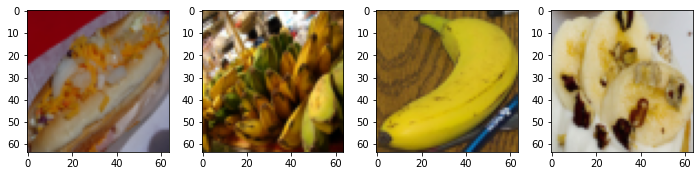

In [18]:
images, labels = next(iter(testloader))
image_shower(images, labels)

outputs = model(images.to(device))

_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join("%5s" %classes[predict] for predict in predicted[:4]))